In [1]:
import torch

from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer

In [2]:
from ir_classification import datasets, models
from ir_classification import vocab as ir_vocab
from ir_classification import train

In [3]:
vocab = ir_vocab.create_vocab_from_tsv("../datasets/systematic_review/phase1.train.shuf.tsv", [2], ngrams=1)
data_columns = [2]
train_dataset = datasets.TSVRawTextMapDataset("../datasets/systematic_review/phase1.train.shuf.tsv", data_columns)
val_dataset = datasets.TSVRawTextMapDataset("../datasets/systematic_review/phase1.dev.shuf.tsv", data_columns)
label_transform = lambda x: x if x > 0 else 0
tokenizer = get_tokenizer("basic_english")
text_transform = lambda x: list(ngrams_iterator(tokenizer(x), 1))
dataloader = datasets.create_torch_dataloader(train_dataset, vocab,  label_transform, text_transform, weighted=True, batch_size=8)
val_dataloader = datasets.create_torch_dataloader(val_dataset, vocab,  label_transform, text_transform, weighted=False, batch_size=1)

In [4]:
num_classes = 2
vocab_size = len(vocab)
embedding_size = 64
model = models.EmbeddingBagLinearModel(vocab_size, embedding_size, num_classes)

In [5]:
from torch.utils.tensorboard import SummaryWriter
EPOCHS = 2 # epoch
LR = 5  # learning rate
BATCH_SIZE = 8 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "max", patience=2)
writer = SummaryWriter()

for i in range(EPOCHS):
    start_iter = len(dataloader) * i
    train.train_epoch(i, model, optimizer, criterion, dataloader, start_iter=start_iter, writer=writer)
    validation_results = train.evaluate_epoch(i, model, criterion, val_dataloader, writer)
    scheduler.step(validation_results["precision"])


Validation: 1: 100%|██████████| 4850/4850 [00:12<00:00, 401.92 batch/s, accurracy=1, loss=6.25e-5]


In [7]:
preds = []
labels = []
for batch in val_dataloader:
    label, text, offset, doc_id = batch
    pred_label = train.predict(model, text)
    preds.append(pred_label)
    labels.append(label.item())

['hash:7f1e17d9-47a9-3d75-b837-49c3d7864c70']
['hash:09cc2d1b-4afd-3171-8ec2-88531f62ce82']
['hash:21c478eb-1ddd-3303-83c6-d28bad52ae34']
['hash:4c57f4c0-5729-3210-b83b-c820da52d085']
['hash:9a2f8948-a902-3597-a78c-d2127b911f11']
['hash:1d6a578d-299e-373c-8d59-33143d1d0bf7']
['hash:e2718a6e-005e-3c92-bd96-ebb75bac038e']
['hash:8a635baf-a38f-396e-b3a0-13b5c5cd75b9']
['hash:2643fe76-b6b1-3025-b6be-bb7125b123fb']
['hash:401de832-7632-39fb-a042-3e1eacd76d9a']
['hash:45bf6edf-d77e-3d38-a4fe-aa844345d8d1']
['hash:b8d7d7c1-5593-312a-9145-f68b900ac44e']
['hash:b3fdc95c-a123-3aab-a8f5-30d7e744bd76']
['hash:01dc4ebf-3da6-30cc-9509-94e91c2c91db']
['hash:ee1521cf-749c-34b9-8e46-b5a57adf007c']
['hash:7bed8e79-5bf2-31e1-afac-12c1d59c310c']
['hash:96819262-1591-3b4e-8e2f-984947ffa66b']
['hash:db2b3442-fc64-3306-8d92-2ab1e7bd409b']
['hash:79db0766-2978-3c18-ae04-20f292af8a11']
['hash:12041345-6e7a-3ad9-9615-819b5c7d4751']
['hash:a216db64-4537-3be7-a5d5-96a500b702be']
['hash:ca449d95-3da5-3494-b2b9-5e2

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      4700
           1       0.22      0.45      0.30       150

    accuracy                           0.93      4850
   macro avg       0.60      0.70      0.63      4850
weighted avg       0.96      0.93      0.94      4850



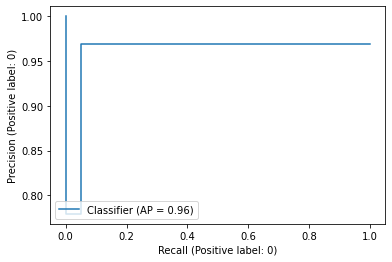

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import PrecisionRecallDisplay
print(classification_report(labels, preds))
PrecisionRecallDisplay.from_predictions(labels, preds)